In [1]:
import os
os.makedirs('runs', exist_ok=True)

In [2]:
import imp
import torch
import torch.nn as nn
import torch.nn.functional as F
from IPython.display import clear_output
from matplotlib import pyplot as plt
plt.style.use('ggplot')

In [ ]:
!pip install albumentations==0.5.1

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [5]:
!cp 'drive/My Drive/Colab Notebooks/CV/Pruning/utils.py' .
!cp 'drive/My Drive/Colab Notebooks/CV/Pruning/resnet.py' .

In [6]:
root_path = '/content/cifar10'
os.makedirs(root_path, exist_ok=True)

In [7]:
import utils
imp.reload(utils)

<module 'utils' from '/content/utils.py'>

In [8]:
from utils import train_model, evaluate, get_train_val_loader, get_test_loader, get_test_results

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
num_workers = 4
batch_size = 128
val_ratio = 0.1

In [ ]:
train_loader, val_loader = get_train_val_loader(data_dir=root_path,
                                                batch_size=batch_size,
                                                val_size=val_ratio,
                                                num_workers=num_workers)

test_loader = get_test_loader(data_dir=root_path,
                              batch_size=batch_size,
                              num_workers=num_workers)

In [12]:
import resnet
imp.reload(resnet)
from resnet import create_resnet20

In [17]:
resnet20_model = create_resnet20()

In [ ]:
resnet20_model.to(device)

In [19]:
n_epochs = 50
opt = torch.optim.SGD(resnet20_model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(opt, milestones=[25, 40], gamma=0.1, last_epoch=-1)

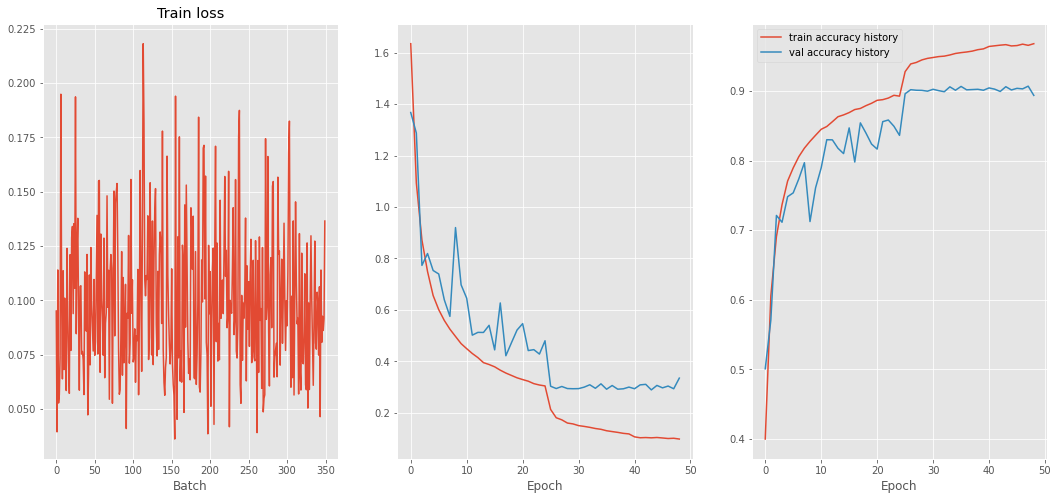

Epoch: 50 | Time: 0m 30s
	Train Loss: 0.099
	 Val. Loss: 0.314


In [20]:
train_model(resnet20_model, 
            device, 
            train_loader, 
            val_loader, 
            opt, 
            criterion, 
            lr_scheduler, 
            n_epochs, 
            clip=1, 
            model_name='resnet20_model.pth')

In [21]:
get_test_results(resnet20_model, device, test_loader, criterion)

Loss on the test data: 0.328
Accuracy on test data: 0.898
